In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pickle
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score # recall scorer
from sklearn.metrics import precision_score # precision scorer
from sklearn.metrics import roc_curve # ROC curve
from sklearn.metrics import f1_score # f1

from sklearn import *
from sklearn.svm import SVC, LinearSVC
import itertools

import os
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec 
from gensim.models import KeyedVectors
from scipy import spatial

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import TruncatedSVD, NMF

import umap
import umap.plot

# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
import joblib
from joblib import Memory

Question 10
(1) GLoVE embeddings allows for a more nuanced and effective capture of word relationships, better handling of word frequency disparities, and more efficient and robust model training. Direct co-occurrence probabilities are heavily influenced by the frequency of words. Some common words occured more often with many other words, which are overshadow more  meaningful co-occurrences. And the ratio of co-occurrence probabilities are heavily dependent on the frequency of words. Ratios help in differentiating between words that are used in similar contexts versus those that are genuinely related. 
(2)No, we have different vector for "running" in this case. The neighbor words will play a very important role in the vector representation of the word. 

In [3]:
embeddings_dict = {}
dimension_of_glove = 300
with open("glove/glove.6B.300d.txt", 'r', encoding='utf-8') as f:

    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [4]:
print(np.linalg.norm(embeddings_dict['woman']-embeddings_dict['man']))
print(np.linalg.norm(embeddings_dict['wife']-embeddings_dict['husband']))
print(np.linalg.norm(embeddings_dict['wife']-embeddings_dict['orange']))

4.7539396
3.1520464
8.667715


(3)
||GLoVE["woman"] - GLoVE["man"]||2 = 4.7539396
||GLoVE["wife"] - GLoVE["husband"]||2 = 3.1520464
||GLoVE["wife"] - GLoVE["orange"] = 8.667715
The value for the first line is very similar to second line. The "husband" is not similar with word "orange" because they have 5.51 similarity score. we also observe that the closest word for "woman" is "woman", "girl" ,and "man" 
(4) The choice between stemming and lemmatization depends on the specific requirements of the task and the nature of the text data.Stemming is a more rudimentary process that chops off the ends of words in the hope of achieving the goal correctly most of the time. It's faster and more straightforward. Useful in tasks where the complexity of the language is less important. Lemmatization involves a more sophisticated analysis of the word to return it to its dictionary form. It takes into consideration the word's part of speech, its meaning in context, and its grammatical usage. Therefor,Lemmatization is chosen over stemming.

In [5]:
root_folder='.'
glove_folder_name='glove'
glove_filename='glove.6B.300d.txt'
glove_path = os.path.abspath(os.path.join(root_folder, glove_folder_name, glove_filename))
word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec(glove_path, word2vec_output_file)
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

C:\Users\josep\AppData\Local\Temp\ipykernel_14628\1082466826.py:6: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_file)


In [6]:
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))

print(find_closest_embeddings(embeddings_dict["woman"])[:3])
print(find_closest_embeddings(embeddings_dict["man"])[:3])
print(find_closest_embeddings(embeddings_dict["wife"])[:3])
print(find_closest_embeddings(embeddings_dict["man"])[:3])

['woman', 'girl', 'man']
['man', 'woman', 'person']
['wife', 'husband', 'daughter']
['man', 'woman', 'person']


Question 11

In [7]:
df = pd.read_csv("Project1-ClassificationDataset.csv")
print('Number of data points : ', df.shape[0])
print('Number of features : ', df.shape[1])

Number of data points :  3476
Number of features :  8


In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)
print('Number of points in train data:', train.shape[0])
print('Number of points in test data:', test.shape[0])

Number of points in train data: 2780
Number of points in test data: 696


In [9]:
import re
def clean(text):
    text = re.sub(r"http\S+", '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    texter = re.sub(r"[0-9]","", texter)
    texter = re.sub('[^a-zA-Z0-9\n]', ' ', texter)
    texter = re.sub('\s+',' ', texter)
    texter = texter.lower()
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [10]:
X_train = train['full_text'].apply(clean)
X_test = test['full_text'].apply(clean)
X_train.head()


16       we re down to the final four after more than ...
2451     sacramento county another earthquake has occu...
1840     this article has been reviewed according to s...
2250     leominster right now david ed good evening th...
2657     at least kids across states have gotten sick ...
Name: full_text, dtype: object

In [11]:
X_test.head()

2125     close get email notifications on subject dail...
2058     this story is part of nature s an annual list...
13       oklahoma city began the nba preseason with a ...
2400     public works crews in pacifica were called in...
10       season tips off with access to out of market ...
Name: full_text, dtype: object

In [12]:
y_train_encoded = train["root_label"].copy()
y_test_encoded = test["root_label"].copy()

y_train_encoded[y_train_encoded == 'sports'] = 0
y_test_encoded[y_test_encoded == 'sports'] = 0

y_train_encoded[y_train_encoded== 'climate'] = 1
y_test_encoded[y_test_encoded == 'climate'] = 1

print("Training Set\n")
print("Original train_dataset:\n" + str(train["root_label"][0:20]))
print("\nBinarized train_dataset:\n" + str(y_train_encoded[0:20]))
print("\nTest Set\n")
print("Original test_dataset:\n" + str(test["root_label"][0:20]))
print("\nBinarized test_dataset:\n" + str(y_test_encoded[0:20]))

Training Set

Original train_dataset:
16       sports
2451    climate
1840    climate
2250    climate
2657    climate
2199    climate
616      sports
1101     sports
2853    climate
2553    climate
3193    climate
1317     sports
664      sports
1264     sports
2898    climate
970      sports
161      sports
880      sports
3459    climate
942      sports
Name: root_label, dtype: object

Binarized train_dataset:
16      0
2451    1
1840    1
2250    1
2657    1
2199    1
616     0
1101    0
2853    1
2553    1
3193    1
1317    0
664     0
1264    0
2898    1
970     0
161     0
880     0
3459    1
942     0
Name: root_label, dtype: object

Test Set

Original test_dataset:
2125    climate
2058    climate
13       sports
2400    climate
10       sports
747      sports
816      sports
1919    climate
3352    climate
3146    climate
441      sports
278      sports
3384    climate
2984    climate
804      sports
2143    climate
2499    climate
3007    climate
2024    climate
2719    climat

In [13]:
class Word2VecVectorizer:
    def __init__(self, model):
        print("Loading in word vectors...")
        self.word_vectors = model
        print("Finished loading in word vectors")
    
    def fit(self, data):
        pass
    
    def transform(self, data):
        v = self.word_vectors.get_vector('king')
        self.D = v.shape[0]

        X = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0
        for sentence in data:
            tokens = sentence.split()
            vecs = []
            m = 0
            for word in tokens:
                try:
                    vec = self.word_vectors.get_vector(word)
                    vecs.append(vec)
                    m += 1
                except KeyError:
                    pass
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n += 1
        print("Number of samples with no words found: %s / %s" % (emptycount, len(data)))
        return X

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [14]:
vectorizer = Word2VecVectorizer(model)

Loading in word vectors...
Finished loading in word vectors


In [15]:
X_train_fit = vectorizer.fit_transform(X_train)
y_train = y_train_encoded.astype(str).astype(int)
X_test_fit = vectorizer.transform(X_test)
y_test = y_test_encoded.astype(str).astype(int)
print(X_train_fit.shape,X_test_fit.shape)

Number of samples with no words found: 0 / 2780
Number of samples with no words found: 0 / 696
(2780, 300) (696, 300)


In [16]:
def train_svm_with_gridsearch(X_train, y_train, X_test):
    clf_cv = svm.SVC(random_state=42)
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 200, 400, 600, 800, 1000],
        'kernel': ['linear']
    }

    grid_search = GridSearchCV(clf_cv, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.best_estimator_.predict(X_test)

    return y_pred, grid_search

# Use the function and get the grid_search object
y_pred_glove, grid_search = train_svm_with_gridsearch(X_train_fit, y_train, X_test_fit)
print(grid_search.best_estimator_)

SVC(C=10, kernel='linear', random_state=42)


In [17]:
print("Accuracy (Best GLoVE classifier):", accuracy_score(y_test,y_pred_glove))
print("Recall (Best GLoVE classifier):", recall_score(y_test,y_pred_glove))
print("Precision (Best GLoVE classifier):", precision_score(y_test,y_pred_glove))
print("F1-Score (Best GLoVE classifier):", f1_score(y_test,y_pred_glove))

Accuracy (Best GLoVE classifier): 0.9583333333333334
Recall (Best GLoVE classifier): 0.961218836565097
Precision (Best GLoVE classifier): 0.9585635359116023
F1-Score (Best GLoVE classifier): 0.9598893499308437


(1)Feature Engineering Process Using GLoVE Embeddings
Text Preprocessing: cleaning: remove punctuation, special characters, and possibly stop words. 
Lemmatization:choose to lemmatize the words to ensure they match the form most likely found in the GLoVE embeddings.We convert each sentence into vectors. All the features which are described in the vectors and that are significant are based in the pre-trained GLoVE embeddingsfile.As a final step, we normalize the final vectors
(2)Linear SVM classifier model is chosen (10) to train and evaluate it with the GLoVE-based feature
Accuracy (Best GLoVE classifier): 0.9583333333333334
Recall (Best GLoVE classifier): 0.961218836565097
Precision (Best GLoVE classifier): 0.9585635359116023
F1-Score (Best GLoVE classifier): 0.9598893499308437

In [18]:
def load_glove_model(glove_file_path):
    # Load GloVe model directly if possible
    return KeyedVectors.load_word2vec_format(glove_file_path, binary=False, no_header=True)

def train_and_evaluate_svm(X_train, y_train, X_test, y_test):
    clf = svm.SVC(kernel='linear', C=1, random_state=42)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    return accuracy_score(y_test, predictions)

root_folder = '.'
glove_folder_name = 'glove'
filenames_glove = ['glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt']
accu_list_glove = []

y_train = y_train_encoded.astype(str).astype(int)
y_test = y_test_encoded.astype(str).astype(int)

for filename in filenames_glove:
    print('Training for:', filename)
    glove_path = os.path.abspath(os.path.join(root_folder, glove_folder_name, filename))

    model = load_glove_model(glove_path)
    vectorizer = Word2VecVectorizer(model)
    X_train_fit = vectorizer.fit_transform(X_train)
    X_test_fit = vectorizer.transform(X_test)

    accuracy = train_and_evaluate_svm(X_train_fit, y_train, X_test_fit, y_test)
    accu_list_glove.append(accuracy)

print("Accuracies:", accu_list_glove)

Training for: glove.6B.50d.txt
Loading in word vectors...
Finished loading in word vectors
Number of samples with no words found: 0 / 2780
Number of samples with no words found: 0 / 696
Training for: glove.6B.100d.txt
Loading in word vectors...
Finished loading in word vectors
Number of samples with no words found: 0 / 2780
Number of samples with no words found: 0 / 696
Training for: glove.6B.200d.txt
Loading in word vectors...
Finished loading in word vectors
Number of samples with no words found: 0 / 2780
Number of samples with no words found: 0 / 696
Training for: glove.6B.300d.txt
Loading in word vectors...
Finished loading in word vectors
Number of samples with no words found: 0 / 2780
Number of samples with no words found: 0 / 696
Accuracies: [0.9410919540229885, 0.9439655172413793, 0.9482758620689655, 0.9482758620689655]


Accuracies: [0.9410919540229885, 0.9439655172413793, 0.9482758620689655, 0.9482758620689655]


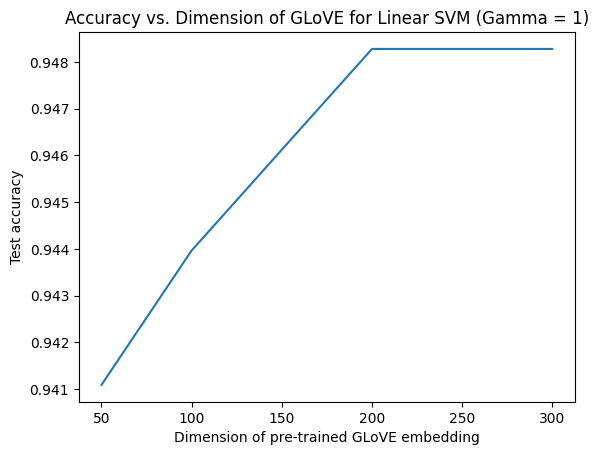

In [19]:
print("Accuracies:", accu_list_glove)
dim_list = [50,100,200,300]
plt.plot(dim_list,accu_list_glove)
plt.title('Accuracy vs. Dimension of GLoVE for Linear SVM (Gamma = 1)')
plt.xlabel('Dimension of pre-trained GLoVE embedding')
plt.ylabel('Test accuracy')
plt.show()

(12)Accuracy vs Dimension plot for GLoVE using Linear SVM as a classifier.We can tell that when the dimension of the GLoVE embedding increases, the accuracy of the test set will also incease. Higer dimension providing us with better feature dependencies and a more accurate model

In [20]:
reduced_dim_embedding = umap.UMAP(n_components=2, metric='euclidean').fit(X_train_fit)
print(reduced_dim_embedding.embedding_.shape)

(2780, 2)


C:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


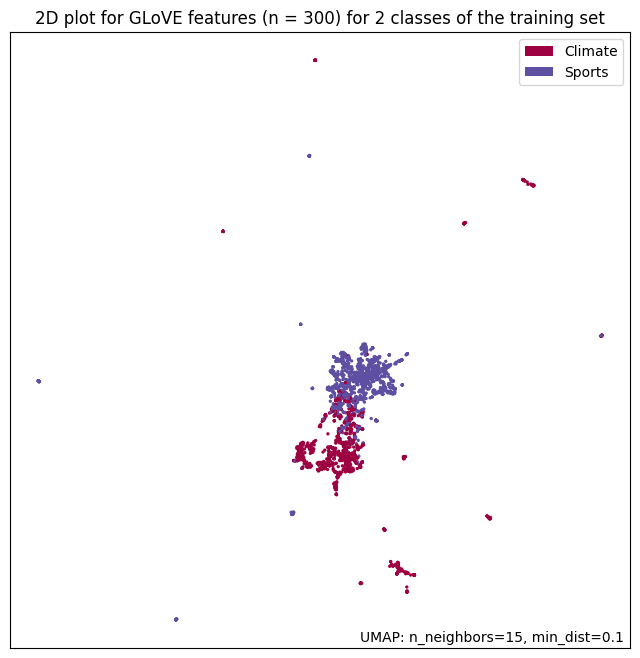

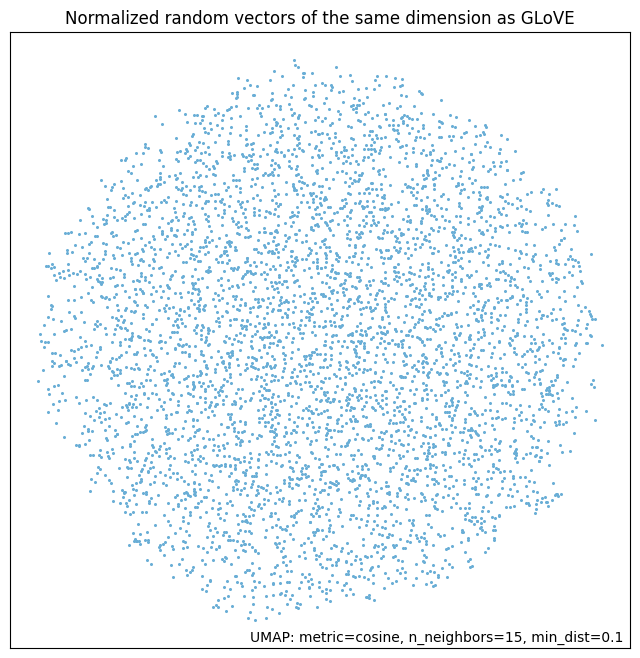

In [21]:

# Fit UMAP for your training data
umap_model = umap.UMAP(n_components=2, metric='euclidean')
umap_model.fit(X_train_fit)

# Prepare labels for the training set
YtrainTextLabel = []
for label in y_train:
    if label == 0:
        YtrainTextLabel.append('Sports')
    else:
        YtrainTextLabel.append('Climate')

# Plotting for GloVe features
f = umap.plot.points(umap_model, labels=np.array(YtrainTextLabel))
plt.title('2D plot for GLoVE features (n = 300) for 2 classes of the training set')

# Fit UMAP for normalized random vectors
s = np.random.normal(0, 1, [4800, 300])
s = s / np.linalg.norm(s, axis=1, keepdims=True)
umap_model_s = umap.UMAP(n_components=2, metric='cosine')
umap_model_s.fit(s)

# Plotting for normalized random vectors
g = umap.plot.points(umap_model_s)
plt.title('2D plot normalized random vectors')



######################

plt.title("Normalized random vectors of the same dimension as GLoVE")
plt.show()

Question 13
On visualizing the 2D plots for GLoVE and random vectors with the same dimension as the GLoVE embeddings, distinct clusters are formed only in the GLoVE model and not for the random vectors.
